# 4-Split multi-input convolutional autoencoder
* Consider invariance property of HGCAL detector:
    * Particles incident to the detector hit equally likely in concentric rings around the beam pipe, i.e. they are invariant in $\phi$.
    * Thus showers generated in these regions can be assumed to also look similar.
    * This motivates using identical encoding units, which produce identical encodings for identical inputs.
* Furthermore, consider detector granularity:
    * Showers usually overlap the input spaces of several encoders (i.e. ECON-T/modules) at once.
    * Thus one encoder must be able to efficiently encode *partial* information.
    * The decoder must demonstrate the ability to recover the full information from those

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
import dataset
import math

In [2]:
nrows, ncols = 28, 28
nencoders    = 4
nsidelen     = nrows // (nencoders//2)
nepochs      = 5
batch_size   = 32
latent_dims  = 1
vmin, vmax   = 0, 1
expl_idx     = 0

### 1. Generate data
* Yield inputs and truths for each batch.
* Inputs are n (square) $m\times m$ images.
* Truth is one (square) $n\times m\times m$ image.

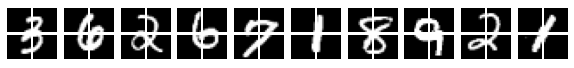

In [3]:
def split(x, nrows=nrows, nsidelen=nsidelen):
    x = x.reshape(nrows//nsidelen,nsidelen,-1,nsidelen)
    x = x.swapaxes(1,2)
    return x.reshape(-1,nsidelen,nsidelen,1)

class BatchGenerator(keras.utils.Sequence):
    
    def __init__(self, X, batch_size):
        self.X = X
        self.batch_size = batch_size
        self.on_epoch_end() # shuffle inputs

    def __len__(self):
        return math.ceil(len(self.X)/self.batch_size)

    def __getitem__(self, idx):
        X_batch = self.X[idx*self.batch_size:(idx+1)*self.batch_size]
        xs_batch = np.array([split(x) for x in X_batch])
        return xs_batch, X_batch

    def on_epoch_end(self):
        self.X = np.random.permutation(self.X)

(X_train, _), (X_test, _) = keras.datasets.mnist.load_data() # load
X_train, X_test = tf.reshape(X_train, (-1,nrows,ncols,1)), tf.reshape(X_test, (-1,nrows,ncols,1)) # reshape
X_train, X_test = tf.cast(X_train, 'float32') / 255., tf.cast(X_test, 'float32') / 255.  # MinMax scale
train_gen = BatchGenerator(X_train, batch_size)
test_gen  = BatchGenerator(X_test, batch_size)

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for ax, (xs, ys) in zip(axs, train_gen):
    for j in range(4):
        r = int(j/2)
        c = j%2
        ins = ax.inset_axes([c*0.55,0.5-r*0.5,0.5,0.5])
        ins.axis('off')
        ins.imshow(xs[expl_idx][j], vmin=vmin, vmax=vmax)  # first input elements of batch
    ax.axis('off')

### 2. Create model
* $n$ Encoders with shared weights produce $n$ latent spaces.
    * Weight sharing is accomplished by using a single encoder model and reshaping.
    * Encoder inputs are reshaped from (28,28) to (4,14,14).
    * Encoder outputs are reshaped from (latent_dims) to (4$\times$latent_dims).
    * This has the effect of sequentially producing 4 encodings, collecting and concatenating them.
* Concatenated latent spaces are fed to (larger) decoder.

In [4]:
class Reshaper(keras.models.Model):
    # Reshape arbitrary input to output along sampling dimension
    def __init__(self, input_shape, output_shape):
        model_in  = keras.layers.Input(shape=input_shape)
        model_out = K.concatenate( (K.variable([-1], dtype='int32'), output_shape) ) # -1 (arbitrary samples)
        shaper = keras.layers.Lambda( lambda x: K.reshape(x, model_out) )(model_in)
        super(Reshaper, self).__init__(inputs=model_in, outputs=shaper)

def build_encoder(latent_dims, nrows=nsidelen, ncols=nsidelen):
    return keras.Sequential([
        keras.layers.Input(shape=(nrows,ncols,1)),
        keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Flatten(),
        keras.layers.Dense(units=latent_dims, activation='linear', use_bias=False),
    ])

def build_decoder(latent_dims, nencoders, nrows=nrows, ncols=ncols):
    return keras.Sequential([
        keras.layers.Input(shape=(nencoders*latent_dims,)),
        keras.layers.Dense(units=nrows//4*ncols//4*16, activation='sigmoid', use_bias=False), # add units to avoid bottleneck forming here.
        keras.layers.Reshape(target_shape=(nrows//4,ncols//4,16)),      # .. reshape those units into channel dimension.
        keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear', use_bias=False),
    ])

encoder = build_encoder(latent_dims)
decoder = build_decoder(latent_dims, nencoders)
input_reshaper = Reshaper([nencoders,nsidelen,nsidelen,1], [nsidelen,nsidelen,1])
latent_space_reshaper = Reshaper([latent_dims], [nencoders * latent_dims])
inputs = keras.layers.Input(shape=(nencoders,nsidelen,nsidelen,1))
output = decoder(latent_space_reshaper(encoder(input_reshaper(inputs))))

foursplit = keras.models.Model(inputs, output)
foursplit.compile(loss='mse', optimizer='adam')

### 3. Train model

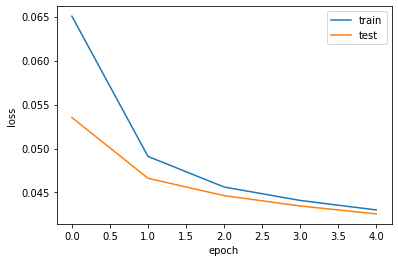

In [5]:
history = foursplit.fit(train_gen, validation_data=test_gen, epochs=nepochs, batch_size=batch_size, verbose=0)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

### 4. Transform into and from latent space
* Latent space can be devided in 4 blocks, generated from partial views (quadrants) on input data.

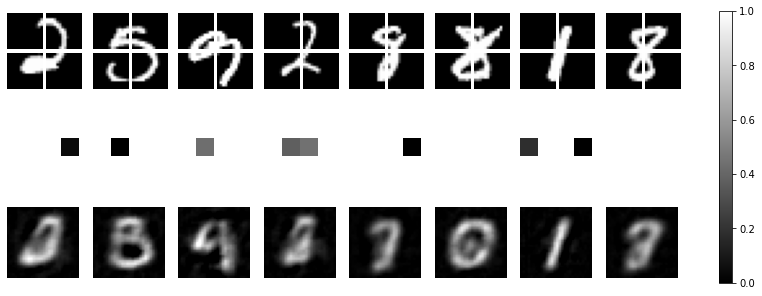

In [19]:
n = 8
plt.figure(figsize=(15, 5))
axs = []
for (xs, ys), i in zip(test_gen, range(n)):
    ax = plt.subplot(3, n, i+1)
    for j in range(4):
        r = int(j/2)
        c = j%2
        ins = ax.inset_axes([c*0.55,0.5-r*0.5,0.5,0.5])
        ins.axis('off')
        ins.imshow(xs[expl_idx][j], vmin=vmin, vmax=vmax)
    ax.axis('off')
    axs.append(ax)
        
    z = encoder_model.predict(xs)
    z = latent_space_reshaper(z)

    axs.append(plt.subplot(3, n, n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(z[j], (1,-1)))
    
    y = foursplit.predict(xs)
    axs.append(plt.subplot(3, n, 2*n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(y[0], (28,28)), vmin=vmin, vmax=vmax)
    
plt.colorbar(ax=axs)

### 5. Interpolation in latent space
* In contrast to `08_MICAE` the learned latent components represent "global" features, not "local", i.e. the change that is caused by varying one component affects the complete output image, not only one quadrant.

In [20]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = np.array(list(kwargs.values()), dtype='float32')
    x_pred = decoder(z.reshape(1,-1))
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

scores = Z[expl_idx]

sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=2.6955339908599854, description='PC1', max=16.831907272338867, min=-1.…

### 6. Properties of 4-Split
* Latent components are correlated.

Cov of latent activations:
 tf.Tensor(
[[10.880096    0.62991786 -0.8413975   7.533773  ]
 [ 0.62991786 14.945865    4.1136413   0.8004727 ]
 [-0.8413975   4.1136413  24.029263    5.2068624 ]
 [ 7.533773    0.8004727   5.2068624  25.027555  ]], shape=(4, 4), dtype=float32)


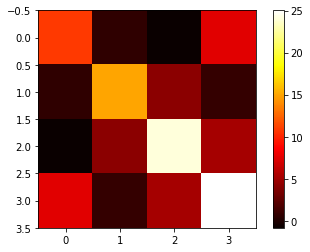

In [21]:
nsamples = Z.shape[0]
fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();

### 7. Calculate MSE

In [22]:
print("MSE: ", foursplit.evaluate(test_gen))

313/313 [==============================] - 0s 1ms/step - loss: 0.0426
MSE:  0.0425603985786438
